# Finding the best-fitting Model 

In this notebook, we test out several classifiers to find the best one and then use the the results to predict which movies are most likely to win the Oscars in 2016. First we spend some time cleaning the data set, split into training and testing sets, then we start testing for classifiers.


#Table of Contents
* [Cleaning data](#Cleaning-data)
* [Data preparation](#Data-preparation)

* [1. Baseline](#1.-Baseline)
* [2. SVM](#2.-SVM)
    * [2.1 Linear SVM](#2.1-Linear-SVM)
    * [2.2 Feature Select SVM](#2.2-Feature-Select-Linear-SVM)
    * [2.3 Linear SVM on Balanced Set](#2.3-Linear-SVM-on-Balanced-Set)
    * [2.4 RBF Based Pipelined \(feature-selected\) SVM on the Subsampled Balanced Set](#2.4-RBF-Based-Pipelined-Feature-Selected-SVM-on-the-Subsampled-Balanced-Set)
    * [2.5 Refit RBF on the Entire Balanced Data Set](#2.5-Refit-RBF-on-the-Entire-Balanced-Data-Set)
    * [2.6 SVM with Polynomial Degree 10](#2.6-SVM-with-Polynomial-Degree-10)

* [3. Logistic](#3.-Logistic)

* [4. Random Forest and Ensemble Methods](#4.-Random-Forest-and-Ensemble-Methods)
    * [4.1 Random Forest](#4.1-Random-Forest)
    * [4.2 Relative Importance](#4.2-Relative-Importance)
    * [4.3 AdaBoost Classifier](#4.3-AdaBoost-Classifier)
    

In [41]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests
import re
import string
import json
from tqdm import tqdm
import dateutil.parser as parser

### Cleaning data

We will clean two sets of data simultaneously.  

`df` contains movies released before 2015. This dataset is used for training model and testing the model.  

`df2015` contins movies released in 2015, which is used for prediction.

In [42]:
df = pd.read_csv('final_table.csv')
df2015 = pd.read_csv('final_table2015.csv')

In [43]:
df.shape, df2015.shape

((1207, 90), (169, 78))

Fix the year variable to be the year the movie is released in. Then create indicator variables for the country, language and rating.

In [44]:
a=[]
for d in df.Released:
    a.append(parser.parse(d).year)
df['Year']=a
#print len(range(8))
#df.head()

In [45]:
a2015=[]
for d in df2015.Released:
    a2015.append(parser.parse(d).year)
df2015['Year']=a2015
#print len(range(8))
#df.head()

In [46]:
l=[]
ll=[]
c=[]
cc=[]
for i in df.index:
    ll.append(str(df.Language[i]).split(", "))
    l.extend(str(df.Language[i]).split(", "))  
    cc.append(str(df.Country[i]).split(", "))
    c.extend(str(df.Country[i]).split(", "))  
     
lang_list=np.unique(l)
country_list=np.unique(c)
df.Language=ll
df.Country=cc

In [47]:
l2015=[]
ll2015=[]
c2015=[]
cc2015=[]
for i in df2015.index:
    ll2015.append(str(df2015.Language[i]).split(", "))
    l2015.extend(str(df2015.Language[i]).split(", "))  
    cc2015.append(str(df2015.Country[i]).split(", "))
    c2015.extend(str(df2015.Country[i]).split(", "))  
     
lang_list2015=np.unique(l2015)
country_list2015=np.unique(c2015)
df2015.Language=ll2015
df2015.Country=cc2015

In [48]:
for i in lang_list:
    df["l_"+i] = [i in m for m in df.Language]

In [49]:
for i in lang_list:
    df2015["l_"+i] = [i in m for m in df2015.Language]

In [50]:
for i in country_list:
    df["c_"+i] = [i in m for m in df.Country]        

In [51]:
for i in country_list:
    df2015["c_"+i] = [i in m for m in df2015.Country]        

In [52]:
for i in ['Film-Noir','Music','War']:
    df2015[i] = [i in m for m in df2015.Country]

In [53]:
a=[]
b=[]
for l in lang_list:
    a.append("l_"+l)
for c in country_list:
    b.append("c_"+c)
a=a[1:] #language column names
#b #country column names

In [54]:
a2015=[]
b2015=[]
for l in lang_list2015:
    a2015.append("l_"+l)
for c in country_list2015:
    b2015.append("c_"+c)
a2015=a2015[1:] #language column names
#b #country column names

In [55]:
df_1=pd.get_dummies(df['Rated'])
df=pd.concat([df,df_1],axis=1)
c=list(df_1.columns)
#c

In [56]:
df_12015=pd.get_dummies(df2015['Rated'])
df2015=pd.concat([df2015,df_12015],axis=1)
c=list(df_12015.columns)
#c

Fill in the missing data.

For the missing values in standardisable variables, we fill them with the corresponding average yearly value. For example, for missing value in 'tomatoRating', we find the year of the missing value and fill it with that year's average 'tomatoRating' value. Because the standardizable variables might be time-invariant, we feel that this method is better than filling it with randomly choose from the non-missing values from the whole dataset.

In [57]:
mean_by_year1 = df['tomatoRating'].groupby(df['Year']).mean()
mean_by_year2 = df['tomatoReviews'].groupby(df['Year']).mean()
mean_by_year3 = df['tomatoUserRating'].groupby(df['Year']).mean()
mean_by_year4 = df['tomatoUserReviews'].groupby(df['Year']).mean()
mean_by_year1[1927] = mean_by_year1[1928]
mean_by_year2[1927] = mean_by_year2[1928]
#mean_by_year4
mean_by_year={}
mean_by_year['tomatoRating']=mean_by_year1
mean_by_year['tomatoReviews']=mean_by_year2
mean_by_year['tomatoUserRating']=mean_by_year3
mean_by_year['tomatoUserReviews']=mean_by_year4

In [58]:
tofill_list=['tomatoRating', 'tomatoReviews', 'tomatoUserRating', 'tomatoUserReviews']
#print tofill_list[0]

for n in tofill_list:
    count=[]
    val=[]
    for y, i in enumerate(df[n]):
        if np.isnan(i)==True:
            count.append(1)
            val.append(mean_by_year[n][df['Year'][y]])
        else:
            count.append(0)
            val.append(i)
            
    df[n]=val
    #print sum(count), len(count)

The list of standardizable variables are continuous variables.

In [59]:
STANDARDIZABLE = ['Runtime', 'A_mean_age', 'A_mean_credit', 'D_mean_age', 'D_mean_credit','mean_rate', 
                  u'imdbRating', u'imdbVotes', u'tomatoRating', u'tomatoReviews', u'tomatoUserRating', 
                  u'tomatoUserReviews']

In [60]:
tofill_list_2015=STANDARDIZABLE
#print tofill_list[0]

for n in tofill_list_2015:
    count=[]
    val=[]
    mean=df2015[n].mean()
    for y, i in enumerate(df2015[n]):
        if np.isnan(i)==True:
            count.append(1)
            val.append(mean)
        else:
            count.append(0)
            val.append(i)
            
    df2015[n]=val
    #print sum(count), len(count)


### Data preparation

**Select relavent features.** There are a total of 154 possible features.

The features variable contains all the features we think would matter for predicting Academy awards. The list inclundes:

Movie run time: ```Runtime```

Movie release year: ```Year```

Rating score from IMDb: `imdbRating`

Number of votes on IMDb: `imdbVotes`

Rating score from Rotten Tomatoes (critics): `tomatoRating`

Number of reviews from Rotten Tomatoes (critics): `tomatoReviews`

User rating score from Rotten Romatoes: `tomatoUserRating`

Number of user reviews from Rotten Tomatoes: `tomatoUserReviews`

Indicator variables of movie genres: ```Action, Adventure, Animation, Biography, Comedy, Crime, Drama, Family, Fantasy, Film-Noir, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western```

Movie budget in USD: ```budget_USD```

Movie Box Office until Dec. 4th, 2015 in USD: ```box_USD```

Cast mean age: ```A_mean_age```

Cast mean credit (average number of movies featured by actors in the cast): ```A_mean_credit```

Director mean age: ```D_mean_age```

Director mean credit (average number of movies directed by the directors): ```D_mean_credit```

Weighted average of ratings on IMDb and Rotten Tomato: ```mean_rate```

Total nominations of cast: ```Anominated```

Total Academy awards won by the cast: ```Awon```

Total nominations of directors: ```Dnominated```

Total Academy awards won by the directors: ```Dwon```

Indicator variables of languages: list ```a```

Indicator variables of countries: list ```b```

Indicator variables of ratings: list ```c```


In [61]:
features= ['Runtime','Year','Action','Adventure','Animation','Biography','Comedy',
           'Crime','Drama','Family','Fantasy','Film-Noir','Horror','Music','Musical','Mystery','Romance',
           'Sci-Fi','Thriller','War','Western','A_mean_age','A_mean_credit','D_mean_age',
           'D_mean_credit','mean_rate', u'imdbRating', u'imdbVotes', u'tomatoRating', u'tomatoReviews',
            u'tomatoUserRating', u'tomatoUserReviews']+a+b+c
len(features)

154

Now we **create our result cloumn**, which takes the value "True" if the film has won at least one award in our list of awards of interest: Best Picture, Best Actor in a Leading Role, Best Actress in a Leading Role, Best Actress in a Supporting Role and Best Actor in a Supporting Role.

In [62]:
resp=df.bp_w + df.ml_w + df.fl_w + df.ms_w + df.fs_w

In [63]:
df['resp']=resp

We first **split the dataframe into training and testing**. To best capture the features and have a test set that best represents the whole dataset. We randomly pick a year in each decade and use these movies as test set. The rest of the movies are in training set.

In [64]:
take=[]
np.random.seed(9)
for t in range(9):
    a=np.random.choice(range(10), size=1, replace=False)+10*t+1927
    take.extend(a)
print take
#print take
df.Year[0] in take 
testdf=df[df['Year'].isin(take)]
#testdf.head()
traindf=df[~df['Year'].isin(take)]
#traindf.head()
traindf.shape, testdf.shape
#testdf.head()

[1935, 1943, 1948, 1966, 1972, 1978, 1988, 2006, 2010]


((1084, 226), (123, 226))

We **create a `mask` variable** which takes the value True if the data entry is in the training set and takes the value False if the data entry is in the testing set.

In [65]:
mask=np.ones(df.shape[0], dtype='int')
mask[testdf.index]=0
mask[traindf.index]=1
mask = (mask==1)
sum(mask),sum(~mask)

(1084, 123)

**Standardize the data**. Use the mask to compute the training and test parts of the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [66]:
for i, r in df2015.iterrows():
    if np.isnan(r.Runtime):
        df2015['Runtime'][i] = 100
        
for i, r in df2015.iterrows():
    if np.isnan(r.mean_rate):
        df2015['mean_rate'][i] = 5

In [67]:
dftouse=df.copy()
dftouse2015=df2015.copy()
#STANDARDIZABLE = ['Runtime','budget_USD', 
                  #'box_USD','A_mean_age', 'A_mean_credit', 'D_mean_age', 'D_mean_credit','mean_rate','Anominated',
                  #'Awon','Dnominated', 'Dwon']

from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    #print type(df)
    #print col
    valstrain=df[col].values[mask]
    valstest=df[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out
    
    out2015=scaler.fit_transform(df2015[col].values)
    dftouse2015[col]=out2015
#dftouse.head()

In [68]:
dftouse.shape, dftouse2015.shape

((1207, 226), (169, 204))

#1. Baseline

Our **baseline model** is no film wins. Since only 20% of films in our whole data set have won the Best Picture award, this baseline will give us an accuracy of 80% on the whole dataset. 

The following line prints the accuracy score of the baseline on the test set and the training set, which is also the percentage of no-award wovies. The accuracy score on the training set is 79.8% and the accuracy score on the test set is 83.7%.


In [69]:
lcols=features
resp="resp"

print "whole data set", 1-(dftouse[resp].mean())#Highly asymmetric
print "training set", 1-(dftouse[resp][mask].mean()), "test set", 1-(dftouse[resp][~mask].mean())

whole data set 0.801988400994
training set 0.797970479705 test set 0.837398373984


We will now take our data and write a classifier to predict the response, which is in the `resp` column of `dftouse`. This response corresponds to asking the question: will this movie win the oscar for best picture or not?

#2. SVM

##2.1 Linear SVM

We set up a classifier using `LinearSVC`. This algorithm implements a linear SVM. We explicitly pass the standard SVM hinge loss. This is only the initial step of the list of SVM classifiers we will try.

In [70]:
from sklearn.svm import LinearSVC
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=dftouse[lcols].values
Yresp=dftouse['bp_w'].values
X2015=dftouse2015[lcols].values

In [71]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [72]:
Xmatrix_train.shape, Xmatrix_test.shape

((1084, 154), (123, 154))

Use `GridSearchCV` over the parameter grid of regularization coefficients in the `Cs` array to get the best fit classifier using 5-fold cross validation. Store the best classifier in  variable `best`. Fit the data again with this best classifier, and report on the accuracy of this classifier. 

In [73]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
parameters = {"C": Cs}

Now we write a function to carry out grid-searched cross validation and use it on the SVM. (Reference: HW3)

The function `cv_optimize`, which uses a Grid Search in parameters, and a default of 5-fold cross-validation. It takes as arguments a classifier `clf`, with hyper-parameter dictionary `parameters`, training feature matrix `X`, response `y`, number of folds `n_folds`, and custom scoring function `score_func`. It performs cross-validation using `GridSearchCV` along with a grid-search of hyperparameters. It obtains the best model by the average cross-validation score (allowing for a custom cross-validation score, not just those provided by `sklearn`), and finally returns this best model. (A custom scorer can be provided in the optional `score_func` argument to `cv_optimize`. Its default value should be `None`.)

This `cv_optimize` function is passed to the `do_classify` function below.

In [74]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

The following code is an edited code from HW3. 

The function `do_classify` provides a general interface to any classifier, "it can take either a `mask` or a `reuse_split` dictionary to specify which is the training set and which is the test set in X and y. In the former case the mask is used to choose which samples to use as training samples and which ones to use as test samples. In the latter case a dictionary is used to directly provide training and test sets. This is useful when the splits already been done and we want to test multiple classifiers on the same test set to compare their performance. An example of the `reuse_split` usage will be seen further down in this notebook. 

We construct the features from `featurenames` columns of the dataframe `indf`, while the column name `targetname` is used with `target1val` as the value that provides a `1` or `+ive` instance. A custom scorer can be provided in the optional `score_func` argument (with default value `None`). `n_folds` is the number of cross-validation folds, set to a default value of 5.

The function prints out the accuracy score on the training and test data, and also the confusion matrix associated with this classifier (more about confusion matrix in the next part of the homework). It returns the best_fit classifier, along with the training and test sets. "


**Note** that we have added classification matrix, which contains precision score, to the output.

In [75]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    training_accuracy
    test_accuracy = clf.score(Xtest, ytest)
    #training_precision = clf.score(Xtrain, ytrain)
    #test_precision = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "#############  classification report   #################"
    print classification_report(ytest, clf.predict(Xtest))
    print #"Precision on training data: %0.2f" % (training_precision)
    print #"Precision on test data:     %0.2f" % (test_precision)
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

Here we also take the function that makes a ROC curve from HW3. "This function uses `roc_curve` from sklearn: note that this function carries out the process we described and gives us back a triplet of `fpr`, `tpr`, and `thresholds`. We also calculate the `auc`, and plot the roc curve with thresholds, skipping every `label` number of thresholds to make labels."

In [76]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

Here we implement the functions and train the linear SVM classifier.

The classification returns accuracy on training data: 0.80 and accuracy on test data: 0.84. From the comfusion matrix, we see that this model is similar to predicting that no movie wins the award. Therefore, when we fit the model on the 2015 data and predict the winners for the 88th Oscar, we might have no winning movie. This is indeed the case, as shown in the following cell.

In [77]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), 
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                   dftouse,lcols, resp,1, mask=mask,score_func='accuracy')

using mask
BEST {'C': 0.01} 0.797970479705 [mean: 0.55904, std: 0.29214, params: {'C': 0.001}, mean: 0.79797, std: 0.00148, params: {'C': 0.01}, mean: 0.44096, std: 0.29214, params: {'C': 0.1}, mean: 0.55904, std: 0.29214, params: {'C': 1.0}, mean: 0.55996, std: 0.29184, params: {'C': 10.0}, mean: 0.55904, std: 0.29214, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.84
[[103   0]
 [ 20   0]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.84      1.00      0.91       103
          1       0.00      0.00      0.00        20

avg / total       0.70      0.84      0.76       123



########################################################
CPU times: user 2.49 s, sys: 28.3 ms, total: 2.51 s
Wall time: 2.73 s


/Users/annie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [78]:
clfsvm = clfsvm.fit(Xmatrix_train, Yresp_train)
print "Numbers of 88th Oscar movie winning movies (using Linear SVM):", sum(clfsvm.predict(X2015))

Numbers of 88th Oscar movie winning movies (using Linear SVM): 0


We'll reuse the training and test sets computed above later, we will put them into a dictionary `reuse_split`.

In [79]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

Then we plot the ROC curve of the Linear SVM model. Notice that our curve is discrete rather than smoothly curved. This means that the model can only provide discrete predictions, rather than a continous score, due to the lack of samples wo have and the small number of continuous features we have. 

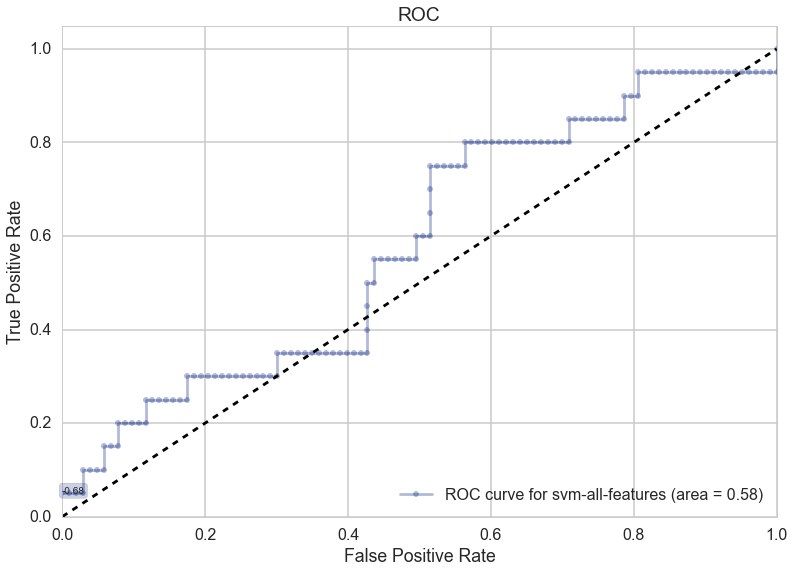

In [80]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=0)

##2.2 Feature Select Linear SVM

We will use feature select SVM in this part of our analysis. This model selects 25 most important features and fits linear SVM classifier using the selected features.

We first set up the pipeline:


In [81]:
from sklearn.svm import SVC
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from scipy.stats.stats import pearsonr

This following function is from HW3. “Let's define a scorer which returns the absolute values of the pearson correlation between the feature and the response for each sample. The specific form of the scorer is dictated to us in the API docs for SelectKBest.”

In [82]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals    

In [83]:
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

This model does not do much better than the previous Linear SVM with all features one, score-wise. This model still predict that all movies earn no award.

In [84]:
pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, resp,1, reuse_split=reuse_split)

using reuse split
BEST {'svm__C': 1e-05} 0.797970479705 [mean: 0.79797, std: 0.00148, params: {'svm__C': 1e-05}, mean: 0.67897, std: 0.23816, params: {'svm__C': 0.001}, mean: 0.79797, std: 0.00148, params: {'svm__C': 0.01}, mean: 0.55996, std: 0.29184, params: {'svm__C': 0.1}, mean: 0.44096, std: 0.29214, params: {'svm__C': 1.0}, mean: 0.67897, std: 0.23816, params: {'svm__C': 10.0}, mean: 0.55904, std: 0.29214, params: {'svm__C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.84
[[103   0]
 [ 20   0]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.84      1.00      0.91       103
          1       0.00      0.00      0.00        20

avg / total       0.70      0.84      0.76       123



########################################################


Let's see what features are selected by the model. Note that most of the continuous random variables are chosen by the model.

In [85]:
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

array([u'Runtime', u'Year', u'Action', u'Biography', u'Drama', u'Thriller',
       u'Western', u'mean_rate', u'imdbRating', u'tomatoRating',
       u'tomatoReviews', u'tomatoUserRating', u'tomatoUserReviews',
       u'l_English', u'l_German', u'l_Polish', u'l_Russian',
       u'l_Scottish Gaelic', u'l_Sioux', u'l_Thai', u'c_Australia',
       u'c_France', u'NOT RATED', u'PG', u'PG-13'], 
      dtype='<U24')

As we can expect, fitting the 2015 movies onto this model, we get no winning movies.

In [86]:
pipelinearsvm = pipelinearsvm.fit(Xmatrix_train, Yresp_train)
sum(pipelinearsvm.predict(X2015))

0

We plot the ROC curve of the two models for comparison. The feature selected SVM model does slightly better than the all feature linear SVM because the green line is slightly toward the northease of the graph.

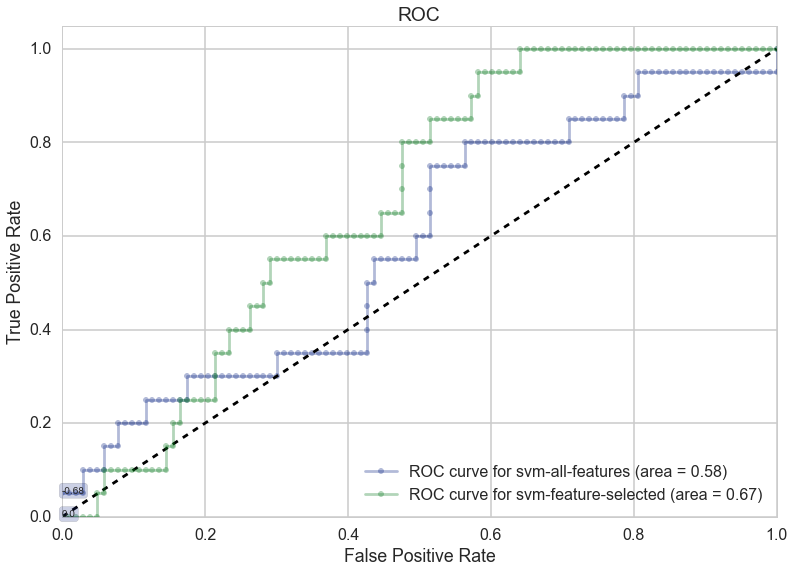

In [87]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=0)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=0);

One of the reasons for this is that SVM does not do terribly well on an unbalanced data set, so **now we balance training set to test set for training.** There are many more negative samples in the training set. We want to balance the negative samples to the positive samples. So lets sample $n_{+}$ samples from the negative samples in the training set (without replacement). We concatenate all the indexes and use them to select a new training set from the old one.
We store these into a new split variable `reuse_split_new`.

In [88]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

219 865


In [89]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)

In [90]:
alli=np.concatenate((jtrain[ytrain==1], ineg))
alli.shape

(438,)

In [91]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((438, 154), (438,))

In [92]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

##2.3 Linear SVM on Balanced Set

With the balanced training set at hand, we can now train the linear SVM on the balance set and on all features. Note that this does not fit the real world sinario because there are a lot more movies that doesn't have any Oscar awards the those who wins the award. However, for the sake of giving us some non-trivial prediction, we test out this model.

Notice that because we have balanced the training set, the accuracy score on the trainign set is now 0.5, and the accuracy score on the test data is 0.16, which suggests the model now predicts that all movies win the award. This does not give us much predictive confidence. 

In [93]:
clfsvm_b, Xtrain_svm2, ytrain_svm2, Xtest_svm2, ytest_svm2=do_classify(clfsvm, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                                       dftouse, lcols, resp,1, mask=alli, reuse_split=reuse_split_new)

using mask
using reuse split
BEST {'C': 0.001} 0.5 [mean: 0.50000, std: 0.00000, params: {'C': 0.001}, mean: 0.50000, std: 0.00000, params: {'C': 0.01}, mean: 0.50000, std: 0.00000, params: {'C': 0.1}, mean: 0.50000, std: 0.00000, params: {'C': 1.0}, mean: 0.50000, std: 0.00000, params: {'C': 10.0}, mean: 0.50000, std: 0.00000, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.50
Accuracy on test data:     0.84
[[103   0]
 [ 20   0]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.84      1.00      0.91       103
          1       0.00      0.00      0.00        20

avg / total       0.70      0.84      0.76       123



########################################################


/Users/annie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


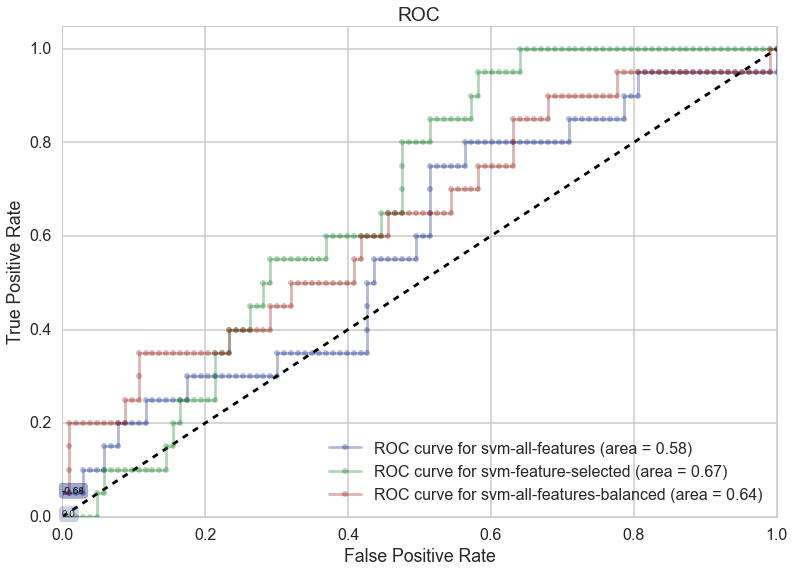

In [94]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=0)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=0);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest_svm2, Xtest_svm2, ax, labe=250, proba=False,  skip=0);

The graph above compares the three models, we see that seill, the SVM on selected features performs the best. Fitting the model to the 2015 data set, we get 0 winning movie.

In [95]:
clfsvm_b_1= clfsvm_b.fit(Xmatrix_train, Yresp_train)
sum(clfsvm_b_1.predict(X2015))

0

##2.4 RBF Based Pipelined Feature Selected SVM on the Subsampled Balanced Set

Let us try a Radial Basis Function (RBF) Kernel, so that we are not restricted to the linear SVM. Note that we use the subsempled set here.

In [96]:
selectorsvm2 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm2 = Pipeline([('select2', selectorsvm2), ('svm2', SVC())])

In [97]:
jtrain_new=np.arange(0, ytrain_new.shape[0])
ipos_new = np.random.choice(jtrain_new[ytrain_new==1], 10, replace=False)
ineg_new = np.random.choice(jtrain_new[ytrain_new==0], 10, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
Xtrain_new2=Xtrain_new[subsampled_i]
ytrain_new2=ytrain_new[subsampled_i]

In [98]:
len(jtrain_new[ytrain_new==1])

219

In [99]:
reuse_split_subsampled=dict(Xtrain=Xtrain_new2, Xtest=Xtest, ytrain=ytrain_new2, ytest=ytest)

In [100]:
param={}
param['svm2__C']=[1e8]
param['svm2__gamma']=[1e-5, 1e-07, 1e-9]
param

{'svm2__C': [100000000.0], 'svm2__gamma': [1e-05, 1e-07, 1e-09]}

This gives us some result. Notice that the model no longer predicts no winning movies, the accuracy on training data: 0.70 and accuracy on test data: 0.66. The precision score on the positive test set is now 0.23, which is an improvement from the 0 in previous models.

In [101]:
%%time
#your code here
pipesvm2, _,_,_,_  = do_classify(pipesvm2, param, dftouse,lcols, resp,1, reuse_split=reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05} 0.45 [mean: 0.45000, std: 0.24495, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05}, mean: 0.45000, std: 0.24495, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07}, mean: 0.40000, std: 0.12247, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09}]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.45
[[42 61]
 [ 7 13]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.86      0.41      0.55       103
          1       0.18      0.65      0.28        20

avg / total       0.75      0.45      0.51       123



########################################################
CPU times: user 250 ms, sys: 7.32 ms, total: 257 ms
Wall time: 264 ms


However, when we implement the model on the training set, we still get no positive prediction.

In [102]:
pipesvm2 = pipesvm2.fit(Xmatrix_train, Yresp_train)
sum(pipesvm2.predict(X2015))

0

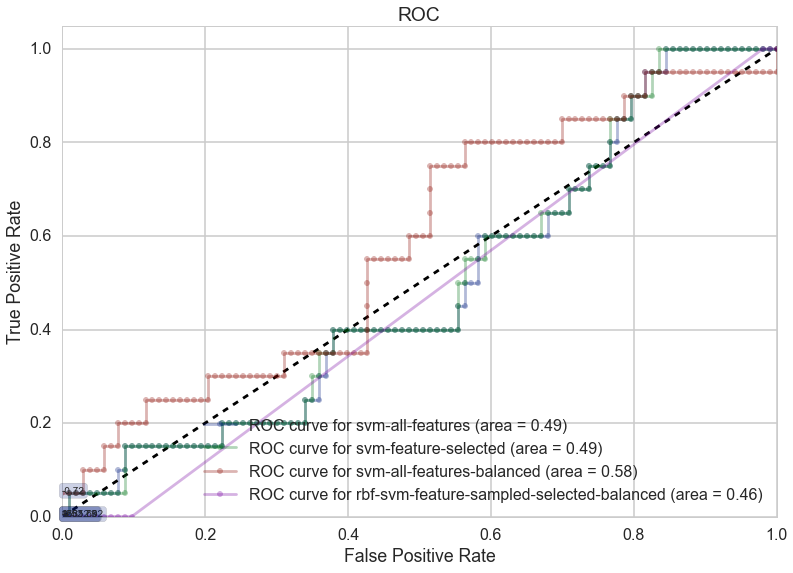

In [132]:
#your code here
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=0)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=0);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest_svm2, Xtest_svm2, ax, labe=250, proba=False,  skip=0);
    make_roc("rbf-svm-feature-sampled-selected-balanced",pipesvm2, ytest, Xtest, ax, labe=250, proba=False,  skip=0);


The ROC curve comparison shows that this model is no better then the SVM on all features model. And we still get 0 positive prediction.

In [104]:
pipesvm2_1= pipesvm2.fit(Xmatrix_train, Yresp_train)
sum(pipesvm2_1.predict(X2015))

0

##2.5 Refit RBF on the Entire Balanced Data Set

Rather than fitting RBF on the subsampled data set, we try to fit it on the balanced data set and see if we do any better. We get accuracy on training data: 0.59 and accuracy on test data: 0.64. The precision on the positive test sets is 0.24.

In [105]:
pipesvm3 = Pipeline([('select2', selectorsvm2), ('svm2', SVC(C=100000000.0, gamma=1e-09))])

In [106]:
%%time
pipesvm3, _,_,_,_  = do_classify(pipesvm3, None, dftouse,lcols, resp,1, reuse_split=reuse_split_new)

using reuse split
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.71
[[76 27]
 [ 9 11]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.89      0.74      0.81       103
          1       0.29      0.55      0.38        20

avg / total       0.80      0.71      0.74       123



########################################################
CPU times: user 39.8 ms, sys: 3.01 ms, total: 42.8 ms
Wall time: 40.4 ms


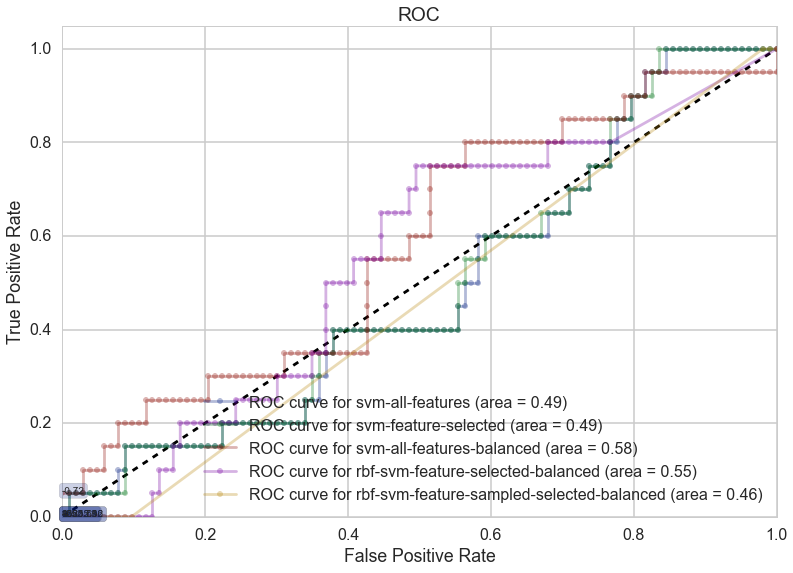

In [133]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=0)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=0);
    #make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest_svm2, Xtest_svm2, ax, labe=250, proba=False,  skip=0);
    make_roc("rbf-svm-feature-selected-balanced",pipesvm3, ytest, Xtest, ax, labe=250, proba=False,  skip=0);
    make_roc("rbf-svm-feature-sampled-selected-balanced",pipesvm2, ytest, Xtest, ax, labe=250, proba=False,  skip=0);


The ROC curve shows thar the model is the best out of all that we have tried. Now we see it it makes any positive prediction on the 2015 data set. (Still No)

In [108]:
pipesvm3_1= pipesvm3.fit(Xmatrix_train, Yresp_train)
sum(pipesvm3_1.predict(X2015))

0

##2.6 SVM with Polynomial Degree 10 

In this final SVM model fitting, we try the SVM model with Polynomial with degree 10. **Note**: In the process of finding the best degree, we tried several degrees and find that they do not make much difference when the degree is larger than 3. 

The accuracy score and the precision score from this model is not much different from the previous one, therefore, there is no surprise that we see no positive prediction when we fit the model to the 2015 data.

In [109]:
selectorsvm4 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm4 = Pipeline([('select4', selectorsvm4), ('svm2', SVC(degree=10))])

In [110]:
%%time
#your code here
pipesvm4, _,_,_,_  = do_classify(pipesvm4, None, dftouse,lcols, resp,1, reuse_split=reuse_split_new)

using reuse split
############# based on standard predict ################
Accuracy on training data: 0.75
Accuracy on test data:     0.63
[[64 39]
 [ 6 14]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.91      0.62      0.74       103
          1       0.26      0.70      0.38        20

avg / total       0.81      0.63      0.68       123



########################################################
CPU times: user 43.6 ms, sys: 2.11 ms, total: 45.7 ms
Wall time: 44.2 ms


In [111]:
pipesvm4 = pipesvm4.fit(Xmatrix_train, Yresp_train)
sum(pipesvm4.predict(X2015))

0

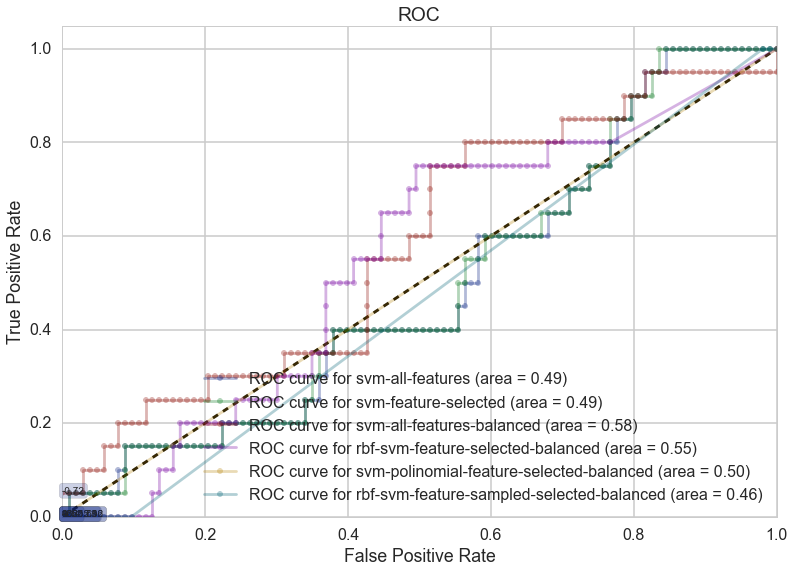

In [134]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=0)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=0);
    #make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest_svm2, Xtest_svm2, ax, labe=250, proba=False,  skip=0);
    make_roc("rbf-svm-feature-selected-balanced",pipesvm3, ytest, Xtest, ax, labe=250, proba=False,  skip=0);
    make_roc("svm-polinomial-feature-selected-balanced",pipesvm4, ytest, Xtest, ax, labe=250, proba=False,  skip=0);
    make_roc("rbf-svm-feature-sampled-selected-balanced",pipesvm2, ytest, Xtest, ax, labe=250, proba=False,  skip=0);

The Roc curves shows that this model in in fact inferior to the other models. Some of the ROC curves are below the 45 degree line.

#3. Logistic

With the SVMs failing to predict positive results, we try Logistic Regression. This part of the code documents our attempt.

In [113]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression(penalty="l1")
parameters = {"C": Cs}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, dftouse, lcols, resp,1, mask=mask, reuse_split=reuse_split)

using mask
using reuse split
BEST {'C': 0.001} 0.797970479705 [mean: 0.79797, std: 0.00148, params: {'C': 0.001}, mean: 0.79797, std: 0.00148, params: {'C': 0.01}, mean: 0.79336, std: 0.00510, params: {'C': 0.1}, mean: 0.77860, std: 0.01999, params: {'C': 1.0}, mean: 0.76292, std: 0.03531, params: {'C': 10.0}, mean: 0.74631, std: 0.02893, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.84
[[103   0]
 [ 20   0]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.84      1.00      0.91       103
          1       0.00      0.00      0.00        20

avg / total       0.70      0.84      0.76       123



########################################################


/Users/annie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [114]:
def t_repredict(est,t, xtest):
    output = []
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return (ypred, p1)

In [115]:
clflog = clflog.fit(Xmatrix_train, Yresp_train)
#clflog.predict_proba(X2015)

Again, we use the data balancing technique on logistics. The accuracy on training data: 0.68 and the accuracy on test data: 0.64. The precision score also improves. It is now 0.92 on the negative test set and 0.27 on the positive test set. We should be able to make positive predictions on the 2015 data set.

In [116]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

clflog_b, Xtrain_log2, ytrain_log2, Xtest_log2, ytest_log2=do_classify(clflog, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                                       dftouse, lcols, resp,1, mask=alli, reuse_split=reuse_split_new)


using mask
using reuse split
BEST {'C': 0.1} 0.634703196347 [mean: 0.50000, std: 0.00000, params: {'C': 0.001}, mean: 0.50000, std: 0.00000, params: {'C': 0.01}, mean: 0.63470, std: 0.07543, params: {'C': 0.1}, mean: 0.59132, std: 0.07005, params: {'C': 1.0}, mean: 0.56164, std: 0.04456, params: {'C': 10.0}, mean: 0.56849, std: 0.05481, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.68
Accuracy on test data:     0.64
[[65 38]
 [ 6 14]]
#############  classification report   #################
             precision    recall  f1-score   support

          0       0.92      0.63      0.75       103
          1       0.27      0.70      0.39        20

avg / total       0.81      0.64      0.69       123



########################################################


/Users/annie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [117]:
clflog_b = clflog_b.fit(Xmatrix_train, Yresp_train)
clflog_b.predict_proba(X2015)
clflog_b.predict(X2015)
a,b=t_repredict(clflog_b, 0.15, X2015)

Note that our dataset is extremely unbalanced. Therefore we should not accept the default 0.5 threshold value of 0.5, but should set it to a lower value. By setting the threhold value to be 0.2, which is approximately the same as the percentage of positive samples in our training data set. We make all the movies that are predicted to win into a dataframe. 

In [135]:
win = []
for i,j in enumerate(a):
    if j == 1:
        win.append((i, b[i]))
#df2015.iloc[win]['Title']
logisticsout = pd.DataFrame(columns=('Movie', 'Winning probability'))
for i in win:
    #print i
    #print df2015.loc[i[0]]['Title'], b[i[0]]
    logisticsout.loc[len(logisticsout)+1]=[df2015.loc[i[0]]['Title'], b[i[0]]]
#df.loc[i]
logisticsout
logisticsout.to_csv('logistics_output.csv')

####Compare with ROC curves

By comparing the SVM with the highest AUC with the logtistics model, we can see that the logistics model performs better based on the ROC curve. Also, the ROC curve of Logistis is smoother than that of SVM.

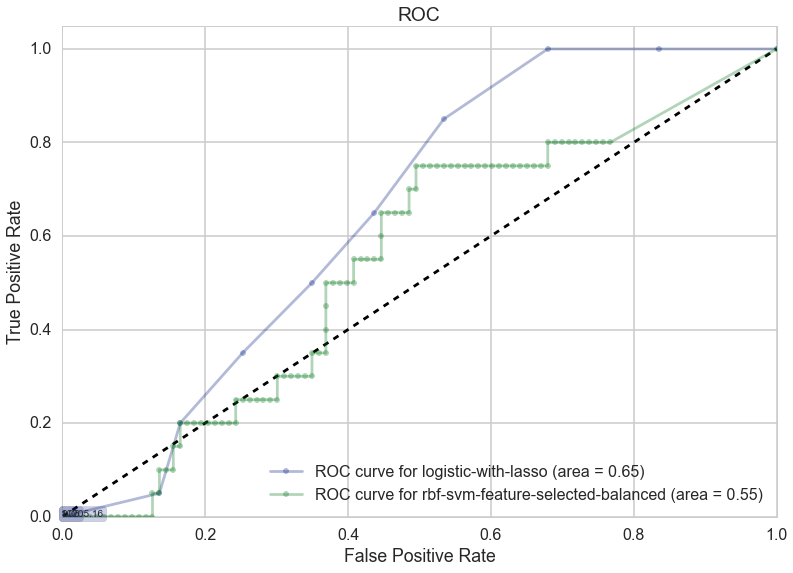

In [145]:
with sns.color_palette("dark"):
    #ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=0)
    #make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=0);
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, None, labe=250, proba=True,  skip=0);
    #make_roc("svm-polinomial-feature-selected-balanced",pipesvm4, ytest, Xtest, ax, labe=250, proba=False,  skip=0);
    make_roc("rbf-svm-feature-selected-balanced",pipesvm3, ytest, Xtest, ax, labe=250, proba=False,  skip=0);

#4. Random Forest and Ensemble Methods


##4.1 Random Forest 


Besides logistics regressio and Random forest, we also try to use random forest and ensemble methods for prediction. Recall from class that the random forest technique works by aggregating the results from a number of randomly perturbed decision trees constructed to explain the data.

In [146]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams


Since there are code ready for us to use, we then just copy the below code for random forest.

In [147]:

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )
    Xplot= np.c_[xx.ravel(), yy.ravel()]

    Z = clfTree1.predict( Xplot )
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)

    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)


In [148]:
Y = df['resp'].values * 1
df_tmp = df[lcols]
X = df_tmp.as_matrix()
print X.shape

(1207, 154)


In [149]:
Xnames = list(df_tmp.columns.values)
len(Xnames)

154

In [150]:
# make sure we didn't get unlucky in our mask selection
print "% Wins in Training:", np.mean(df.resp[mask])
print "% Wins in Testing:", np.mean(df.resp[~mask])

% Wins in Training: 0.202029520295
% Wins in Testing: 0.162601626016


In [151]:
from sklearn.ensemble import RandomForestClassifier
%time
clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'resp', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
using mask


/Users/annie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 3} 0.260175574432 [mean: 0.17617, std: 0.10191, params: {'n_estimators': 1}, mean: 0.15309, std: 0.11608, params: {'n_estimators': 2}, mean: 0.26018, std: 0.10907, params: {'n_estimators': 3}, mean: 0.16355, std: 0.11130, params: {'n_estimators': 4}, mean: 0.19255, std: 0.06156, params: {'n_estimators': 5}, mean: 0.17445, std: 0.13305, params: {'n_estimators': 6}, mean: 0.21395, std: 0.13017, params: {'n_estimators': 7}, mean: 0.12522, std: 0.07967, params: {'n_estimators': 8}, mean: 0.15612, std: 0.09063, params: {'n_estimators': 9}, mean: 0.17620, std: 0.13300, params: {'n_estimators': 10}, mean: 0.19113, std: 0.10929, params: {'n_estimators': 11}, mean: 0.14943, std: 0.10145, params: {'n_estimators': 12}, mean: 0.18937, std: 0.10371, params: {'n_estimators': 13}, mean: 0.16970, std: 0.12551, params: {'n_estimators': 14}, mean: 0.17019, std: 0.09780, params: {'n_estimators': 15}, mean: 0.10968, std: 0.08429, params: {'n_estimators': 16}, mean: 0.18099, std: 0.09

/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Below are the model predicted to win from the random forest model, there are 5 movies in total. We can see that these 5 movies are quite different from those predicted from the logistics model. It indicates that our models are not consistent with the predictions, therefore lower the reliability of the predictions. Also, the predictions from random forest are not stable. In other words, the movies being predicted are not the same everytime.

In [152]:
out = clfForest.predict(df2015[lcols]) == 1
ramdonForestout = df2015.iloc[out]

## 4.2 Relative Importance

Following the standard procedure of random forest, we plot out the relative importance of features. We can see that tomatoUserReviews, Year, Runtime and A_mean_age are among the top important features.

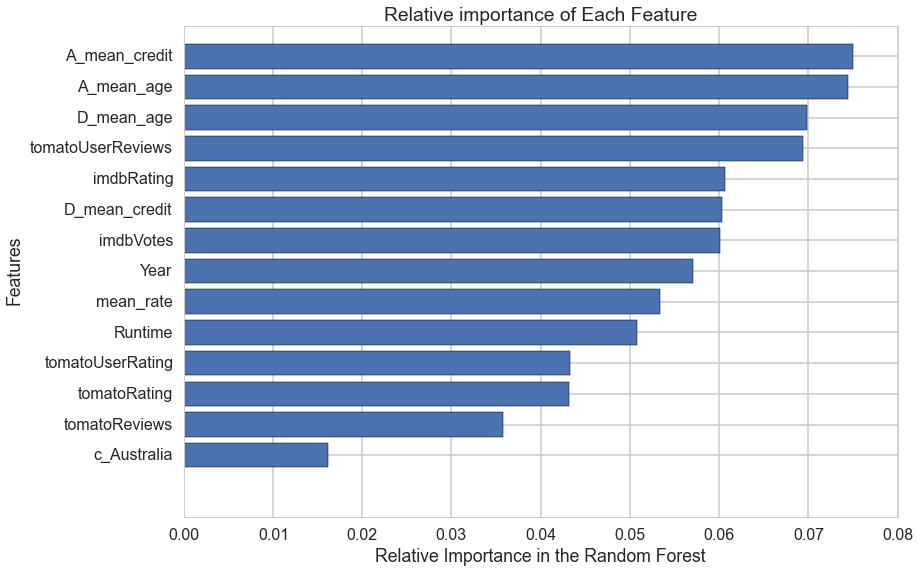

In [153]:
importance_list = clfForest.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
importance_list = importance_list[140:166]
name_list = name_list[140:166]
plt.barh(range(len(name_list)),importance_list, align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

##4.3 AdaBoost Classifier

We also use the AdaBoost classifier from the lab to make prediction to see if there is any different.

In [154]:
from sklearn.ensemble import AdaBoostClassifier
%time
clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'resp', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.01 µs
using mask


/Users/annie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 13} 0.272916056594 [mean: 0.20618, std: 0.14113, params: {'n_estimators': 10}, mean: 0.18219, std: 0.15145, params: {'n_estimators': 11}, mean: 0.20679, std: 0.13746, params: {'n_estimators': 12}, mean: 0.27292, std: 0.15061, params: {'n_estimators': 13}, mean: 0.26063, std: 0.14828, params: {'n_estimators': 14}, mean: 0.25351, std: 0.14338, params: {'n_estimators': 15}, mean: 0.20142, std: 0.11562, params: {'n_estimators': 16}, mean: 0.24458, std: 0.14696, params: {'n_estimators': 17}, mean: 0.23325, std: 0.13535, params: {'n_estimators': 18}, mean: 0.23983, std: 0.12656, params: {'n_estimators': 19}, mean: 0.23821, std: 0.13106, params: {'n_estimators': 20}, mean: 0.24114, std: 0.12753, params: {'n_estimators': 21}, mean: 0.24055, std: 0.12704, params: {'n_estimators': 22}, mean: 0.23429, std: 0.12532, params: {'n_estimators': 23}, mean: 0.24753, std: 0.13658, params: {'n_estimators': 24}, mean: 0.24037, std: 0.13323, params: {'n_estimators': 25}, mean: 0.19417,

/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/annie/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [155]:
out = clfAda.predict(df2015[lcols]) == 1
df2015.iloc[out]

,Unnamed: 0,imdbID,Title,Released,Country,Language,Rated,Runtime,Year,imdbRating,imdbVotes,tomatoConsensus,tomatoFresh,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Nominated Oscars,Won Oscars,Other wins,Other nominations,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,l_Zulu,l_nan,c_Algeria,c_Australia,c_Austria,c_Belgium,c_Brazil,c_Canada,c_China,c_Colombia,c_Czech Republic,c_Czechoslovakia,c_Denmark,c_Ecuador,c_France,c_Germany,c_Greece,c_Hong Kong,c_Hungary,c_Iceland,c_India,c_Ireland,c_Italy,c_Japan,c_Luxembourg,c_Mexico,c_Netherlands,c_New Zealand,c_Norway,c_Poland,c_Romania,c_Russia,c_South Africa,c_South Korea,c_Soviet Union,c_Spain,c_Sweden,c_Switzerland,c_Taiwan,c_UK,c_USA,c_United Arab Emirates,c_West Germany,Film-Noir,Music,War,NOT RATED,PG,PG-13,R


Unfortunately, there are no movie predicted to win the oscar. Therefore this model is not very good.

Therefore, we used SVM, logistics regression, Random forest and AdaBoost classifier to make our predictions. Only logistics and random forest gave us some movie predictions. They are:

In [156]:
logisticsout

,Movie,Winning probability
1,Jurassic World,0.170459
2,Mad Max: Fury Road,0.189764
3,Straight Outta Compton,0.228626
4,Spotlight,0.154131
5,Spectre,0.170223
6,Avengers: Age of Ultron,0.357325
7,Furious 7,0.220408
8,The Hateful Eight,0.243750
9,The Martian,0.264459
10,Bridge of Spies,0.187564


In [157]:
for i in ramdonForestout.Title:
    print i

San Andreas
Run All Night
Barney Thomson
Hot Pursuit
The Gift
